In [1]:
using Plots
using LinearAlgebra
using FFTW

In [2]:
module Test
    struct inipara #変更しないパラメータ
        nr::Int64 
        nz::Int64
        h::Float64 
        e::Float64 
        cy::Matrix{Float64}
        simpson::Matrix{Float64}
    end

    struct  targetpara
        k::Float64
        c0::Float64
        M1::Int64 #実数
        M2::Int64 #整数
        a::Float64 
        b::Float64
        nsteps::Float64
        dt0::Float64
    end
end

Main.Test

In [3]:
using.Test
nr = 100 # number of computational grids
nz = 100
h =2/nr # spacing of computational grid [m]
e = 0.03; # interfacial thickness [m]


In [4]:
simpson=ones(nz,nr*2)
for i in 1:nz
    for j in 1:nr*2
        i=i-1
        j=j-1
        if i==0 || i==nz-1
            ki=1
        elseif i%2==0 && i!=nz-1
            ki=2
        else
            ki=4
        end

        if j==0 || j==nr*2-1
            kj=1
        elseif j%2==0 && j!=nr*2-1
            kj=2
        else
            kj=4
        end
        i=i+1
        j=j+1
        simpson[i,j]=1*ki*kj
    end 
end

In [5]:
cy=zeros(nz,nr*2)
for i in 1:nz
    for j in 1:nr*2
        if j<nr+1
            q=j-0.5
        else
            q=abs(nr*2-j+0.5)
        end
        cy[i,j]=q
    end 
end

In [121]:
u0=zeros(ComplexF64, nz, nr)
for i in 1:nz
    for j in 1:nr
        r=sqrt((i*h-1)^2+((j-0.5)*h)^2)
        #R=abs(sqrt(1+12*(j*h)^2))/4
        R=sqrt((2*((i*h)-1))^2+(((j-0.5)*h)^2))
        u0[i,j]=tanh((1-R)/(sqrt(2)*e))
    end
end

In [122]:
parai=Test.inipara(nr,nz,h,e,cy,simpson);

In [123]:
function complete(u)
    u_c=zero(u)
    u_c=zero(eltype(u))
    u_r=reverse(u,dims=2)
    u_c=cat(u,u_r,dims=2)
end;

In [124]:
uc=complete(u0)
u0r=real(u0);

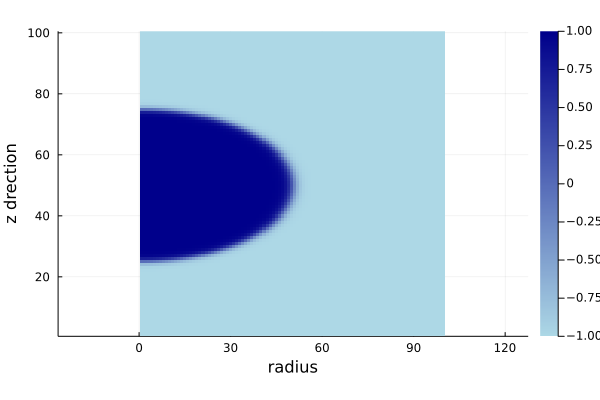

In [125]:
x=1:nr
y=1:nz
heatmap(x,y,u0r, color=:blues,aspect_ratio = 1,xlabel = "radius", ylabel = "z drection")

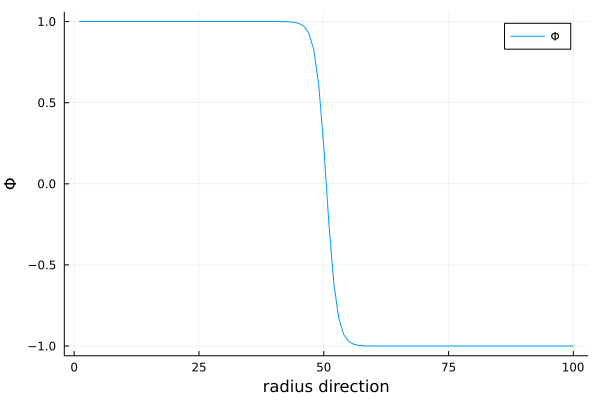

In [126]:
plot(u0r[50,:],label="Φ",xlabel = "radius direction", ylabel = "Φ")

In [127]:
u0r[50,1]

1.0

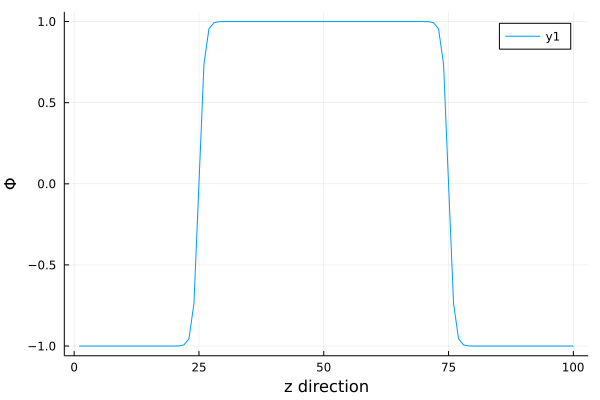

In [128]:
plot(u0r[:,1],xlabel = "z direction", ylabel = "Φ")

In [129]:
mr=nr*2
mz=nz
kr=fftfreq(mr)*mr*2*pi/(2*h*nr)
kz=fftfreq(mz)*mz*2*pi/(h*nr);

In [130]:
FFT=plan_fft(uc);

In [131]:
function derivative(f::Matrix{ComplexF64})

    ft=similar(f)
    fr=similar(f)
    fz=similar(f)
    frr=similar(f)
    fzz=similar(f)

    mul!(ft,FFT,f)
    ftrr=@. ft.*(im*kr').^2
    ftzz=@. ft.*(im*kz).^2

    ldiv!(fr,FFT,(im*kr'.*ft))
    ldiv!(frr,FFT,ftrr)

    ldiv!(fz,FFT,(im*kz.*ft))
    ldiv!(fzz,FFT,ftzz)

    clu=@. (frr)+(fzz)+(fr)/parai.cy
    (clu,fr,fz)
end

derivative (generic function with 1 method)

In [132]:
a0=derivative(uc);

In [133]:
function properties(fc::Matrix{ComplexF64},df::Tuple{Matrix{ComplexF64}, Matrix{ComplexF64}, Matrix{ComplexF64}})
    f=real(fc)
    V=0.0;S=0.0;E=0.0
    clu,fr,fz=df

    dv=@. ((f)+1)*parai.cy*parai.simpson*0.5
    V=sum(dv)*(parai.h^3)*pi/9

    gf2=@. fr^2+fz^2
    dbc=@. parai.e*gf2/2+(f^2 .-1)^2/(4*e)
    s=@. parai.cy*dbc.*simpson
    S=real(sum(s)*(parai.h^3)*3/(2*sqrt(2))*pi/9)

    dE=real(@. 0.5*k*parai.e*abs(clu-(f^2-1)*f/e^2)^2)
    W=sum(@. dE*parai.cy*parai.simpson)*(parai.h^3)*pi/9
    E=W+paraf.M1*(V-paraf.a)^2/2+paraf.M2*(S-paraf.b)^2/2

    V,S,E,W,dE
end

properties (generic function with 1 method)

In [134]:
c=properties(uc,a0);
c[1:4]

(2.1030015881146817, 9.426447640332364, 23863.631181278404, 23863.631181278404)

In [135]:
function dEh(f::Matrix{ComplexF64},df::Tuple{Matrix{ComplexF64}, Matrix{ComplexF64}, Matrix{ComplexF64}},res)
    dEh=0.0

    rf=df[1]
    rf2=derivative(f.^2)[1]
    r2f=derivative(rf)[1]
    rf3=derivative(f.^3)[1]

    V,S=res[1:2]

    dE=@. paraf.k*((parai.e*r2f)+(1-3*f^2)*rf/parai.e+(f-f^3).*(1-3*f^2)/(parai.e^3)-(rf3-rf)/parai.e)
    A=(V-paraf.a)*0.5
    B=@. (S-paraf.b)*((f^3-f)/parai.e-rf*parai.e)
    dEh=@. (paraf.M1*A)+paraf.M2*B+dE
end

dEh (generic function with 1 method)

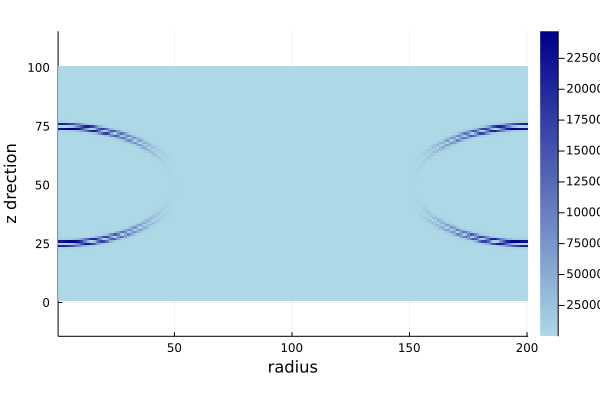

In [150]:
x=1:nr*2
y=1:nz
heatmap(x,y,c[5], color=:blues,aspect_ratio = 1,xlabel = "radius", ylabel = "z drection")

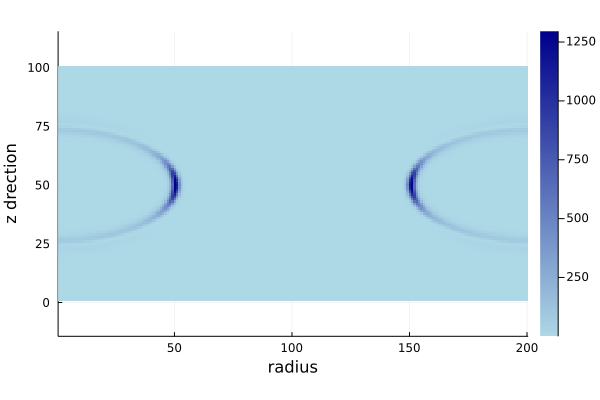

In [184]:
x=1:nr*2
y=1:nz
heatmap(x,y,resU[5], color=:blues,aspect_ratio = 1,xlabel = "radius", ylabel = "z drection")

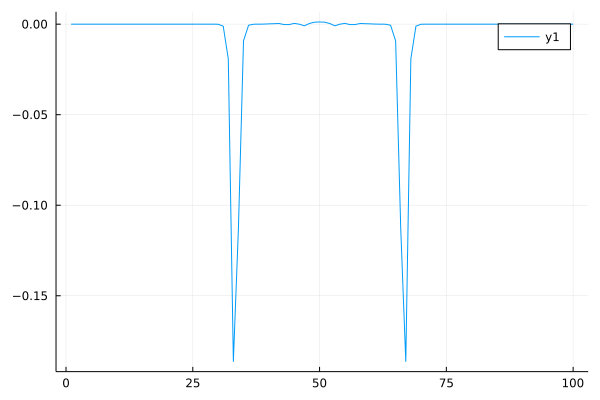

In [53]:
#plot(a0[1][50,:])
plot(real(a0[2])[:,1])
#plot!(a0[1][:,20])

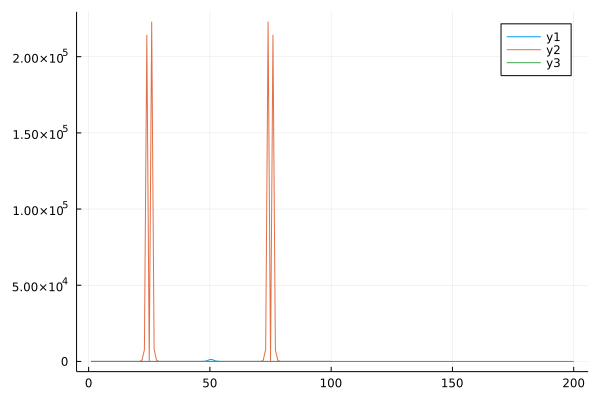

In [152]:
plot(c[5][50,1:nr])
plot!(c[5][:,1])
plot!(c[5][20,:])

In [55]:
plot(cp[5][50,1:nr])
plot!(cp[5][:,1])
plot!(cp[5][20,:])

MethodError: MethodError: no method matching getindex(::typeof(cp), ::Int64)

In [56]:
plot(resU[5][50,1:nr])
plot!(resU[5][:,1])
plot!(resU[5][25,:])

UndefVarError: UndefVarError: resU not defined

In [57]:
dEh0=real(dEh(uc,a0,c));

UndefVarError: UndefVarError: c not defined

In [58]:
plot(dEh0[50,:])

UndefVarError: UndefVarError: dEh0 not defined

In [59]:
x=1:nr*2
y=1:nz
heatmap(x,y,dEh0, color=:blues,aspect_ratio = 1,xlabel = "radius", ylabel = "z drection")

UndefVarError: UndefVarError: dEh0 not defined

In [60]:
function Heun(u0::Matrix{ComplexF64},dt0::Float64)
    u=u0
    dt=dt0
    du=derivative(u)
    res_u=properties(u,du)
    v1=dt*dEh(u,du,res_u)

    u2=u+v1
    du2=derivative(u2)
    res_u2=properties(u2,du2)
    v2=dt*dEh(u2,du2,res_u2)
    u_n=u-0.5*(v1+v2)
    u_n,res_u[3]
end

Heun (generic function with 1 method)

In [61]:
function RK(u0::Matrix{ComplexF64},dt0::Float64)
    u=u0
    dt=dt0
    du=derivative(u)
    res_u=properties(u,du)
    k1=dt*dEh(u,du,res_u)

    u2=u+k1*dt/2
    du2=derivative(u2)
    res_u2=properties(u2,du2)
    k2=dt*dEh(u2,du2,res_u2)

    u3=u+k2*dt/2
    du3=derivative(u3)
    res_u3=properties(u3,du3)
    k3=dt*dEh(u3,du3,res_u3)

    u4=u+k3*dt
    du4=derivative(u4)
    res_u4=properties(u4,du4)
    k4=dt*dEh(u4,du4,res_u4)

    u_n=u-dt*(k1+2*k2+2*k3+k4)

    u_r=u_n[:,1:nr]
    u_c=complete(u_r)
    u_c,res_u[3]
end

RK (generic function with 1 method)

In [62]:
function simple(u0::Matrix{ComplexF64},dt0::Float64)
    u=u0
    dt=dt0
    du=derivative(u)
    char=properties(u,du)
    gfE=real(dEh(u,du,char))

    u_n=u-gfE*dt
    u_n,char[3]
end

simple (generic function with 1 method)

In [63]:
function forward_eular(f0::Matrix{ComplexF64},nsteps::Float64,dt0::Float64)
    u=f0
    u_b=u0
    dt=dt0

    E=Vector{Float64}()
    M=Vector{Float64}()
    T=Vector{Float64}()
    for t in 1:nsteps
        u_n,E_o=RK(u,dt)
        
        du_n=derivative(u_n)
        E_n=properties(u_n,du_n)

        if E_n[3]>E_o
            dt=0.5*dt
            continue

        else
            u_b=u
            u=u_n
            append!(E,E_n[3])
            append!(M,E_n[4])
            append!(T,dt)
        end
        
        if t%10==0
            dt=2*dt
        end
    end
    
    N=length(E)

    threshold=zeros(nz,nr*2)
    for i in 1:nz
        for j in 1:nr
           threshold[i,j]=abs(u[i,j])*1e-4-abs(u[i,j]-u_b[i,j]) 
        end
    end
    
    if minimum(threshold)>=0
        println(N-1,"歩以内でよく収束できました")
    else
        println(N-1,"歩以内でよく収束できませんでした")
    end

    if T[N]<1e-10
        println("時間判定で収束できました")
    else
        println("時間判定で収束できませんでした")
    end

    return u,u_b,E,M,T,N
end

forward_eular (generic function with 1 method)

In [138]:
c[1:4]

(2.1030015881146817, 9.426447640332364, 23863.631181278404, 23863.631181278404)

up=U
ap=derivative(up)
c_p=properties(up,ap)
upr=real(up)

u1=U
a1=derivative(u1)
c1=properties(u1,a1)
u1r=real(u1);


In [82]:
ui=U
ai=derivative(ui)
ci=properties(ui,ai)
uir=real(ui)
ci[1:4]

(1.408493742271835, 7.576917168118293, 367.20852962346515, 367.20852962346515)

In [169]:
M1=0
M2=0
a=2.1030 #round(ci[1],digits=4)
b=11.6609#round(ci[2]+0.14,digits=4)
k = 10 # bending rigidcy
c0 = 0
nsteps=1000
dt0=1e-6
paraf=Test.targetpara(k,c0,M1,M2,a,b,nsteps,dt0);

In [170]:
U,u_b,E,M,T,N=forward_eular(uc,paraf.nsteps,paraf.dt0)
Ur=real(U);

905歩以内でよく収束できました
時間判定で収束できませんでした


In [171]:
dU=derivative(U)
resU=properties(U,dU)
resU[1:4]

(2.1071283483294536, 8.67420149205858, 201.19150189756226, 201.19150189756226)

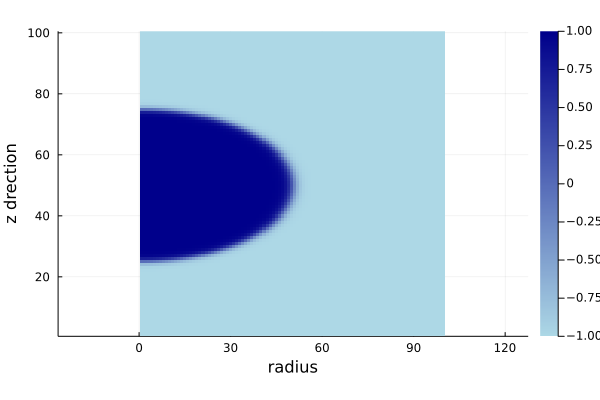

In [172]:
x=1:nr
y=1:nz
heatmap(x,y,u0r[:,1:nr], color=:blues,aspect_ratio = 1,xlabel = "radius", ylabel = "z drection")

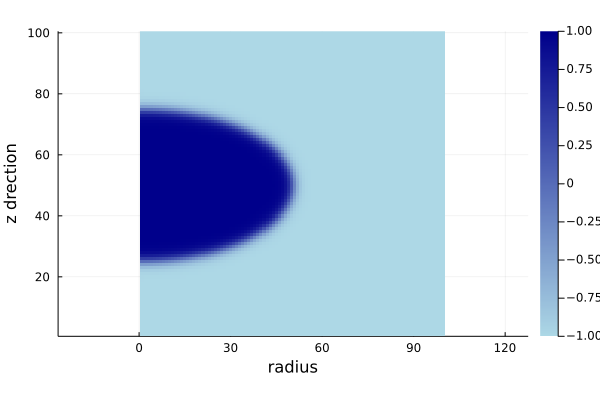

In [173]:
x=1:nr
y=1:nz
heatmap(x,y,Ur[:,1:nr], color=:blues,aspect_ratio = 1,xlabel = "radius", ylabel = "z drection")

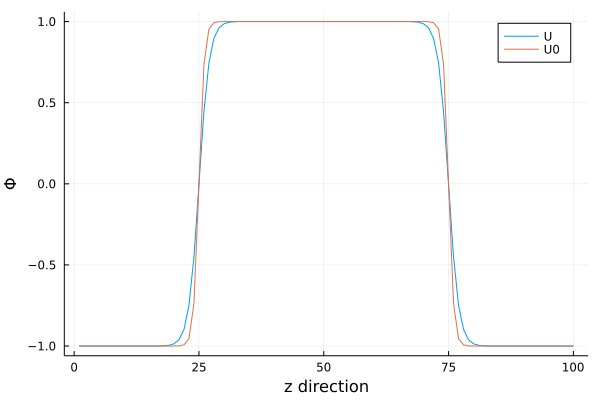

In [174]:
plot(Ur[:,1],label="U")
plot!(u0r[:,1],label="U0",xlabel = "z direction", ylabel = "Φ")

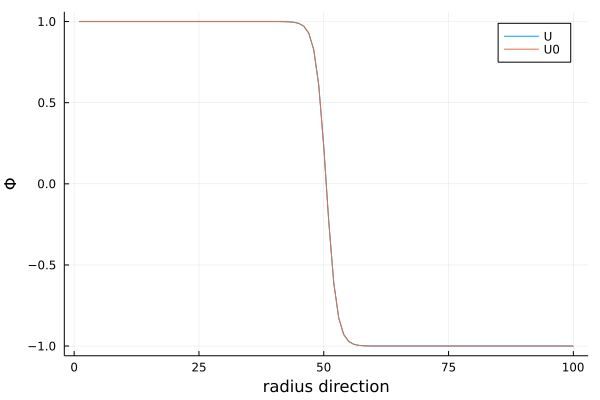

In [175]:
plot(Ur[50,1:nr],label="U")
plot!(u0r[50,1:nr],label="U0",xlabel = "radius direction", ylabel = "Φ")

In [176]:
p=abs.(Ur[50,1:nr])
abs(-argmin(p))*h

1.0

In [177]:
p=abs.(u0r[50,1:nr])
abs(argmin(p))*h

1.0

In [178]:
p=abs.(Ur[:,1])
abs(argmin(p)-50)*h

0.5

In [179]:
p=abs.(u0r[:,1])
abs(argmin(p)-50)*h

0.5

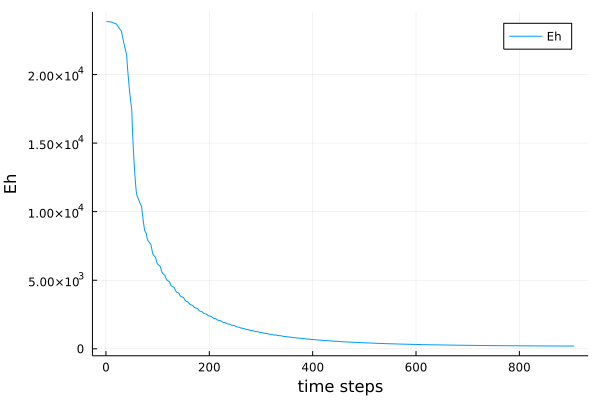

In [180]:
plot(E,label="Eh",xlabel = "time steps", ylabel = "Eh")

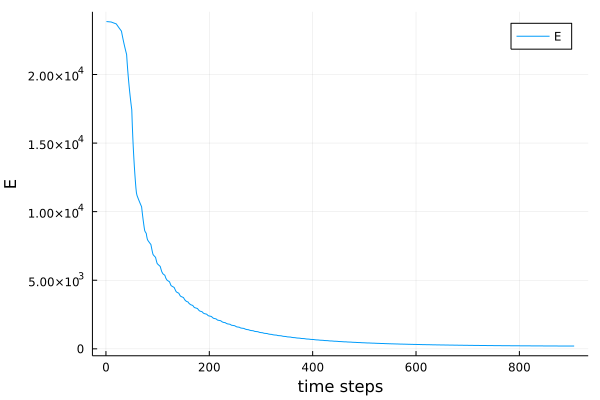

In [181]:
plot(M,label="E",xlabel = "time steps", ylabel = "E")

In [182]:
print(E[N-10:N])

[202.5928133488805, 202.52735367972767, 202.26672603755077, 202.0090562816867, 201.75937747520894, 201.70428492216567, 201.46146034473287, 201.37938917674663, 201.3154502714131, 201.25325466146825, 201.19150189756226]

In [183]:
E[1]

23860.053388815064

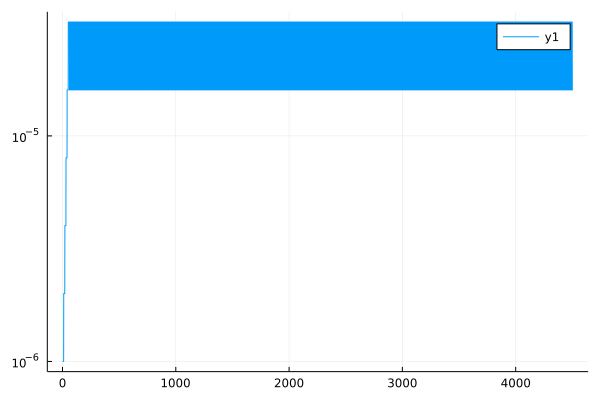

In [112]:
plot(T, yaxis=:log)

In [92]:
println(T[N-20:N])

[1.6e-5, 1.6e-5, 1.6e-5, 3.2e-5, 3.2e-5, 3.2e-5, 1.6e-5, 1.6e-5, 1.6e-5, 1.6e-5, 1.6e-5, 1.6e-5, 3.2e-5, 3.2e-5, 3.2e-5, 3.2e-5, 1.6e-5, 1.6e-5, 1.6e-5, 1.6e-5, 1.6e-5]


In [1641]:
sum(T)

3.351013999999994